<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Sam/Sartorius_segmentation_kaggle_Sam_v020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'global-wheat-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F19989%2F1160143%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T150520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db6ed2ea81cf12cbf04fa35fdb566fcab49583b1c09c798936dd449bdef28e0f3023dd470ab87d8652b8e2505e935289a8ecc63b7be1751c1fc926226bc5caec529e916b679314637725cca154818b5df793a5cf884063d048d6c58a794ae60380e9c3794adb096427ba88886c695c0b2fd104a9cec0bbbe4cafa4d802fecc23da498cf5ae21a0c91dcc1f5fe9478c9b908358c32e6b51cd5e7bcbc518f6bd413567b6a665c425c85781bd7eebd796f18f7ba17bace2ef6ee8cf2b5b8d3475d155145212cb0a687eae82aec3d61092d2f71eb5770acdbe896e70a42867be9a952b16abb2a6d5a6531ee3f11d79159cf420d7f0ef34a830ea08dd9e5f3f1b06e97'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 636694264 bytes downloaded
Downloaded and uncompressed: global-wheat-detection
Data source import complete.


# About this Notebook

Object Detection is a problem which is not only a bit complex but also computationally expensive, due to the number of components to it. I always wanted to learn it and I got really excited when I saw a Kaggle competition on it , although I was not able to fully concentrate on it due to other competitions up untill now. While I was learning all the different concepts in Object Detection , I came across Facebook's **Detection tranformer DETR** , launched in April 2020 . It's still quite new but the resuts are astonishing and the model itself is very fast . In this notebook, I explore this new architecture,its working and fine tune it for Wheat Detection competition Dataset.

Note that for now this is just a baseline to demonstrate the architecture and its working ,it does not aim at getting very good results on lb,this will be a work in progress,and I will soon update with full training and a separate

# Update Log

### V2
* As I was made aware that I was printing the target boxes instead of predicted boxes , I have corrected it , I am really sorry , It was an honest mistake
* Thanks to PRVI and his valuable suggestions , I have incorporated the following changes :
  * Normalizing bounding boxes
  * Using label 0 for main class

The code for the changes has been taken from [here](https://www.kaggle.com/prokaj/end-to-end-object-detection-with-transformers-detr#Creating-Dataset)

# DETR (Detection Transformer)

Attention is all you need,paper for Transformers,changed the state of NLP and has achieved great hieghts. Though mainly developed for NLP , the latest research around it focuses on how to leverage it across different verticals of deep learning. Transformer acrhitecture is very very powerful, and is something which is very close to my part,this is the reason I am motivated to explore anything that uses transformers , be it google's recently released Tabnet or OpenAI's ImageGPT .

Detection Transformer leverages the transformer network(both encoder and the decoder) for Detecting Objects in Images . Facebook's researchers argue that for object detection one part of the image should be in contact with the other part of the image for greater result especially with ocluded objects and partially visible objects, and what's better than to use transformer for it.

**The main motive behind DETR is effectively removing the need for many hand-designed components like a non-maximum suppression procedure or anchor generation that explicitly encode prior knowledge about the task and makes the process complex and computationally expensive**

The main ingredients of the new framework, called DEtection TRansformer or DETR, <font color='green'>are a set-based global loss that forces unique predictions via bipartite matching, and a transformer encoder-decoder architecture.</font>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/05/Screenshot-from-2020-05-27-17-48-38.png)

<font color='red'>Interesting Right?? Want to learn more please bare with me, as always I will try to explain everything</font>

For Fully understanding DETR I recommend read [this](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) blog<br><br>
However if you want in-depth knowledge and are a video person like please see the video in the cell below
You can find the video in youtube [here](https://www.youtube.com/watch?v=T35ba_VXkMY)

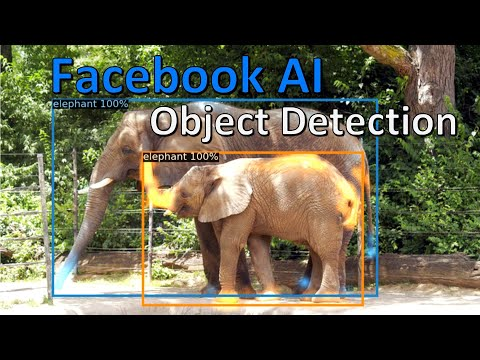

In [ ]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('T35ba_VXkMY',width=600, height=400)

# Using DETR without Fine-Tuning

* Before learning how to fine tune DETR if you want to use and play with DETR directly on some sample images , please refer the video [here](https://www.youtube.com/watch?v=LfUsGv-ESbc)
* [Here](https://scontent.flko3-1.fna.fbcdn.net/v/t39.8562-6/101177000_245125840263462_1160672288488554496_n.pdf?_nc_cat=104&_nc_sid=ae5e01&_nc_ohc=KwU3i7_izOgAX9bxMVv&_nc_ht=scontent.flko3-1.fna&oh=64dad6ce7a7b4807bb3941690beaee69&oe=5F1E8347) is the link to the paper
* [Here](https://github.com/facebookresearch/detr) is link to their github repo for code and model zoo
* They recently added a wrapper to use DETR from Detectron2 API

# Wheat Detection Competition With DETR

So I wanted to try DETR and what could be greater oppurtunity than a kaggle competition to test a model's potential. I just joined two days ago and from what I have analyzed these are by far the best practices for this competition :-
* Use Stratified Kfold because of different sources of Images
* Use Cut-mix for better model generalization
* Use WBF ensemble for unifying predictions of Kfold model

Besides these I found gem of an EDA kernel , It gives very valuable insigts , you can have a look [here](https://www.kaggle.com/aleksandradeis/globalwheatdetection-eda) by aleksandra .Here are the conclusions derived from that kernel
* Images are taken at different zoom levels. Crop and resize data augmentations to be used for model training.
* Images are taken at various lighting conditions. Special filters should be used to address that.
* Bounding boxes are messy!

**There are some Giant bounding boxes and some micro bounding boxes removal of which have reported bad lb, so I assume the noise is present in the test setas well, hence keeping them would be more benificial**

Keeping all this in find we start with coding DETR , **Note that this code can be used and easily modified to other object detection tasks**

In [ ]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 265 (delta 0), reused 1 (delta 0), pack-reused 264
Receiving objects: 100% (265/265), 12.88 MiB | 19.53 MiB/s, done.
Resolving deltas: 100% (123/123), done.


* Now if you have seen the video , you know that DETR uses a special loss called Bipartite Matching loss where it assigns one ground truth bbox to a predicted box using a matcher , thus when fine tuning we need the matcher (hungarian matcher as used in paper) and also the fucntion SetCriterion which gives Bipartite matching loss for backpropogation. This is the reason for forking the github repo

* So I did not know that we can add the path to environment variables using sys , hence I was changine directories , but now I have made changes so I do not have to change directories and import detr easily. A big Thanks to @prvi for his help

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

<ipython-input-4-d6044858034a>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

In [ ]:
n_folds = 5
seed = 42
num_classes = 4
num_queries = 800
null_class_coef = 0.5
BATCH_SIZE = 2
LR = 2e-5
EPOCHS = 2

In [ ]:
BASE_PATH = "dataset/sartorius-cell-instance-segmentation"
TRAIN_PATH = BASE_PATH + "/train"
TEST_PATH = BASE_PATH + "/test"
TRAIN_CSV = BASE_PATH + "/train.csv"

IMG_WIDTH = 704
IMG_HEIGHT = 520

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

# Dictionaries to classify each type of cell
CELL_TYPE_DICT = {"astro": 0, "cort": 1, "shsy5y": 2}
DICT_TO_CELL = {0: "astro", 1: "cort", 2: "shsy5y"}
MASK_THRESHOLD_DICT = {1: 0.55, 2: 0.75, 3:  0.6}
MIN_SCORE_DICT = {1: 0.55, 2: 0.75, 3: 0.5}

# Normalize to resnet mean and std if True.
NORMALIZE = False

# Seed Everything

Seeding everything for reproducible results

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed_everything(seed)

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [ ]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [ ]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


# Augmentations

* As suggested by aleksendra in her kernel ,augentations will play a major role and hence took her up advice and use awesome augmentations , cut-mix and other will be included in future versions

In [ ]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),

                      A.VerticalFlip(p=0.5),

                      A.Resize(height=512, width=512, p=1),

                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [ ]:
DIR_TRAIN = '../input/global-wheat-detection/train'

class WheatDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms


    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # DETR takes in data in coco format
        boxes = records[['x', 'y', 'w', 'h']].values

        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels =  np.zeros(len(boxes), dtype=np.int32)


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']


        #Normalizing BBOXES

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

In [ ]:

def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        # Check if any of the normalized values are greater than 1
        if any(coord > 1 for coord in normalized_bbox):
            print(f"Normalized values greater than 1 detected: {normalized_bbox}")

        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes

In [ ]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [ ]:
# Install gdown:
try:
    import gdown
except ImportError:
    !pip install gdown

# Install tqdm:
try:
    import tqdm
except ImportError:
    !pip install tqdm

In [ ]:
import collections
# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score

# General Import which are used in this file
import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import requests
import zipfile
from pathlib import Path
import gdown
from sklearn.metrics import fbeta_score
import torch
from torchvision.transforms import functional as F
from pathlib import Path
import zipfile
import gdown

import collections
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.ops import box_convert, generalized_box_iou

In [ ]:


class ImageCellDataset(Dataset):
    def __init__(self, directory_path, data_frame, transformation_steps=None):
        self.transformation_steps = transformation_steps
        self.directory_path = directory_path
        self.data_frame = data_frame
        self.img_height = IMG_HEIGHT
        self.img_width = IMG_WIDTH
        self.cells_data = collections.defaultdict(dict)

        grouped_df = self.data_frame.groupby(['id', 'cell_type'])['annotation'].apply(list).reset_index()

        for idx, record in grouped_df.iterrows():
            self.cells_data[idx] = {
                'cell_id': record['id'],
                'file_path': os.path.join(self.directory_path, record['id'] + '.png'),
                'cell_annotations': record["annotation"],
                'type': CELL_TYPE_DICT[record["cell_type"]]
            }


    # get the item and load annotations (mask) accordingly
    def __getitem__(self, index):
        cell_data = self.cells_data[index]
        image_file = cell_data["file_path"]
        image = Image.open(image_file).convert("RGB")
        num_objects = len(cell_data['cell_annotations'])
        masks = np.zeros((num_objects, self.img_height, self.img_width), dtype=np.uint8)
        bounding_boxes = []

        for i, annotation in enumerate(cell_data['cell_annotations']):
            decoded_mask = decode_rle(annotation, (self.img_height, self.img_width))
            decoded_mask = Image.fromarray(decoded_mask)
            decoded_mask = np.array(decoded_mask) > 0
            masks[i, :, :] = decoded_mask
            box = find_bounding_box(decoded_mask)

            bounding_boxes.append(box)


        # Prepare labels based on cell type
        labels = [cell_data["type"] for _ in range(num_objects)]

        # Convert bounding_boxes from Corner Points Format to CXCW format
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor




        # print(f"Bounding box initial: {bounding_boxes[0]}")

        # print(f"Bounding box after convertion: {bounding_boxes[0]}")
        #bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        cell_id_tensor = torch.tensor([index])
        areas = (bounding_boxes[:, 3] - bounding_boxes[:, 1]) * (bounding_boxes[:, 2] - bounding_boxes[:, 0])
        not_crowded = torch.zeros((num_objects,), dtype=torch.int64)

        target_dict = {
            'boxes': bounding_boxes,
            'labels': labels,
            'masks': masks,
            'image_id': cell_id_tensor,
            'area': areas,
            'iscrowd': not_crowded
            # 'file_path': image_file
        }


        if self.transformation_steps:
            image, target_dict = self.transformation_steps(image, target_dict)

        # do normalization and conversation here
        boxes = target_dict['boxes']
        converted_boxes = torch.zeros_like(boxes)

        for i, box in enumerate(boxes):
            converted_boxes[i] = box_convert(box, in_fmt='xyxy', out_fmt='cxcywh')
            #print(converted_boxes[i])
        bounding_boxes = converted_boxes
        bounding_boxes = normalize_bbox(bounding_boxes,rows=520,cols=704)
        bounding_boxes = torch.as_tensor(bounding_boxes, dtype=torch.float32)  # Ensure bounding_boxes is a torch tensor


        target_dict['boxes'] = bounding_boxes
        return image, target_dict

    def __len__(self):
        return len(self.cells_data)


# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [ ]:
# class DETRModel(nn.Module):
#     def __init__(self,num_classes,num_queries):
#         super(DETRModel,self).__init__()
#         self.num_classes = 4
#         self.num_queries = 800

#         self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
#         self.in_features = self.model.class_embed.in_features

#         self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
#         self.model.num_queries = 800
#         # Change the number of queries by adjusting the query embedding matrix
#         self.model.query_embed = nn.Embedding(self.num_queries, self.model.transformer.d_model)


#     def forward(self,images):
#         return self.model(images)

In [ ]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel, self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # Load the pre-trained DETR model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)


        # Change the number of queries by adjusting the query embedding matrix
        self.model.query_embed = nn.Embedding(self.num_queries, self.model.transformer.d_model)

        # Adjust the class embedding layer to the number of classes
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)


    def forward(self, images):
        return self.model(images)

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [ ]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [ ]:
def transform_targets(targets):
    # Initialize the new list structure
    targets_new = []

    # Assuming all lists in 'targets' are of the same length
    for i in range(len(next(iter(targets.values())))):  # Iterate through the length of any list in 'targets'
        # Construct new dict for each index, pulling the corresponding item from each list in 'targets'
        new_dict = {key: value[i] for key, value in targets.items()}
        targets_new.append(new_dict)

    return targets_new

# Training Function

Training of DETR is unique and different from FasteRRcnn  and EfficientDET , as we train the criterion as well , the training function can be viewed here : https://github.com/facebookresearch/detr/blob/master/engine.py

In [ ]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        for key in list(targets.keys()):
          if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
              targets[key] = [item.to(device) for item in targets[key]]
        #print("Input Shape: ", images[0].shape)
        #print("Input Data: ", images[0])
        output = model(images)
        #print("Output  logits: ",output['pred_logits'])
        #print("Output  boxes: ", output['pred_boxes'])


        targets_new = transform_targets(targets)

        #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
        #print(output['pred_logits'].shape)
        probabilities = torch.sigmoid(output['pred_logits'])
        # Find the indices of the max probabilities
        max_indices = torch.argmax(probabilities, dim=-1)
        # Check how often the max index is not the last index (index 3)
        not_last_index_count = torch.sum(max_indices != (4 - 1))
        num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
        missing_objects = num_objects_gt-not_last_index_count
        print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )


        loss_dict = criterion(output, targets_new)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

# Eval Function

In [ ]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            for key in list(targets.keys()):
              if isinstance(targets[key][0], torch.Tensor):  # Check if the first item is a tensor
                  targets[key] = [item.to(device) for item in targets[key]]

            output = model(images)
            targets_new = transform_targets(targets)

            #ground_truth_labels = torch.stack(targets['labels'], dim=0) # shape list with len --> shape [batch_size,num objects in image]
            probabilities = torch.sigmoid(output['pred_logits'])
            # Find the indices of the max probabilities
            max_indices = torch.argmax(probabilities, dim=-1)
            # Check how often the max index is not the last index (index 3)
            not_last_index_count = torch.sum(max_indices != (4 - 1))
            num_objects_gt = targets_new[0]['labels'].shape[0] + targets_new[1]['labels'].shape[0]
            missing_objects = num_objects_gt-not_last_index_count
            print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

            loss_dict = criterion(output, targets_new)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

# Engine

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from pathlib import Path
import zipfile
import gdown

# Setup paths and folders names and urls
data_path = Path("dataset")
download_path = Path("kaggledownload")

#dataset_url = 'https://drive.google.com/uc?id=1syZoLGGeFiFErCFL_iI1VO_4k2jLEaPv&confirm=t'
dataset_url = 'https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t'


# If the image folder doesn't exist, download it
if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"Did not find {data_path} directory, creating one...")
    data_path.mkdir(parents=True, exist_ok=True)
    download_path.mkdir(parents=True, exist_ok=True)

print("Downloading dataset...")
gdown.download(dataset_url, str(download_path / "sartorius-cell-instance-segmentation.zip"), quiet=False)


Did not find dataset directory, creating one...


Downloading...
From: https://drive.google.com/uc?id=15XRITzdvdmE4HIsU9oAFgsipIARc_rhF&confirm=t
To: /content/kaggledownload/sartorius-cell-instance-segmentation.zip
100%|██████████| 2.48G/2.48G [00:16<00:00, 148MB/s]


'kaggledownload/sartorius-cell-instance-segmentation.zip'

In [ ]:
# Unzip data
with zipfile.ZipFile(str(download_path / "sartorius-cell-instance-segmentation.zip"), "r") as zip_ref:
    print("Unzipping train dataset data...")
    zip_ref.extractall(data_path)

Unzipping train dataset data...


In [ ]:
import numpy as np
def decode_rle(rle_string, dimensions, fill_value=1):
  """
  Decodes a run-length encoded string into a binary mask.

  Parameters:
  - rle_string: The run-length encoded string (e.g., "2 3 5 2" means start at 2, length 3, start at 5, length 2)
  - dimensions: Tuple indicating the shape of the output mask (height, width)
  - fill_value: The value to fill the mask with where the RLE indicates; default is 1

  Returns:
  - A 2D numpy array representing the mask, where filled areas are marked with `fill_value` and the rest are 0.
  """

  # Split the RLE string into a list of strings, then convert every string into an integer
  numbers = [int(num) for num in rle_string.split()]

  # Extract start positions and lengths from the list of numbers
  start_positions = numbers[::2]
  lengths = numbers[1::2]

  # Calculate end positions for each run
  end_positions = [start + length for start, length in zip(start_positions, lengths)]

  # Initialize a flat image array with zeros
  flat_image = np.zeros(dimensions[0] * dimensions[1], dtype=np.float32)

  # Fill the specified positions in the flat image array
  for start, end in zip(start_positions, end_positions):
      flat_image[start:end] = fill_value

  # Reshape the flat image array back into the specified dimensions
  return flat_image.reshape(dimensions)

import numpy as np

def encode_rle(image_matrix):
  """
  Encodes a binary image matrix into a run-length encoding string.

  Parameters:
  - image_matrix: A 2D numpy array representing the image to be encoded. Expected to contain binary values (0s and 1s).

  Returns:
  - A string representing the run-length encoded image, where each pair of numbers represents a start position and the length of consecutive 1s.
  """

  # Find indices of all 1s in the flattened image array
  one_positions = np.where(image_matrix.flatten() == 1)[0]

  # Initialize the list to hold the encoding
  encoding = []

  # Track the previous position to determine the start of a new run
  previous_position = -2

  # Iterate through all positions of 1s
  for position in one_positions:
      # If current position is not consecutive, start a new run
      if position > previous_position + 1:
          encoding.extend((position + 1, 0))  # +1 for 1-based indexing
      encoding[-1] += 1  # Increment the length of the current run
      previous_position = position

  # Join all elements in the list as a string separated by spaces
  return ' '.join(map(str, encoding))

def eliminate_overlaps(primary_mask, additional_masks):
  """
  Removes pixels from the primary mask where it overlaps with any of the additional masks.

  Parameters:
  - primary_mask: A 2D numpy array representing the primary mask to be modified.
  - additional_masks: A list of 2D numpy arrays, each representing a mask to check for overlaps with the primary mask.

  Returns:
  - The modified primary mask with overlapping pixels set to 0.
  """

  # Iterate through each of the additional masks
  for mask in additional_masks:
      # Find overlapping pixels between the primary mask and the current additional mask
      overlap = np.logical_and(primary_mask, mask)

      # Check if there is any overlap
      if np.sum(overlap) > 0:
          # Set overlapping pixels in the primary mask to 0
          primary_mask[overlap] = 0

  # Return the modified primary mask
  return primary_mask

import numpy as np

def create_boxed_image(coordinates):
    """
    Draws a rectangular box on an image represented by a numpy array, based on given coordinates.

    Parameters:
    - coordinates: A list of four elements representing the box's corners [xmin, ymin, xmax, ymax].

    Returns:
    - A 2D numpy array (image) with dimensions IMG_HEIGHT x IMG_WIDTH,
      where pixels inside the box are set to 1, and the rest are 0.
    """

    # Initialize a blank image with zeros
    image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Extract and convert the box coordinates to integers
    xmin, ymin, xmax, ymax = map(int, coordinates)

    # Draw top and bottom lines of the box
    for x in range(xmin, xmax):
        if xmin != 0 and xmax != IMG_WIDTH:  # Check to prevent drawing outside the image
            image[ymin-1][x] = 1  # Draw top line
            image[ymax-1][x] = 1  # Draw bottom line

    # Draw left and right lines of the box
    for y in range(ymin, ymax):
        if ymin != 0 and ymax != IMG_HEIGHT:  # Check to prevent drawing outside the image
            image[y][xmax-1] = 1  # Draw right line
            image[y][xmin-1] = 1  # Draw left line

    # Return the image with the drawn box
    return image

import numpy as np

def find_bounding_box(mask):
    """
    Calculates the bounding box of a non-zero area in a mask.

    Parameters:
    - mask: A 2D numpy array representing the mask from which to calculate the bounding box.

    Returns:
    - A list containing the coordinates of the bounding box: [xmin, ymin, xmax, ymax].
    """

    # Find the indices of non-zero elements in the mask
    nonzero_indices = np.where(mask)

    # Calculate the minimum and maximum x (column) indices
    left_bound = np.min(nonzero_indices[1])
    right_bound = np.max(nonzero_indices[1])

    # Calculate the minimum and maximum y (row) indices
    top_bound = np.min(nonzero_indices[0])
    bottom_bound = np.max(nonzero_indices[0])

    # Return the bounding box coordinates
    return [left_bound, top_bound, right_bound, bottom_bound]

def merge_masks(mask_list, threshold):
    """
    Merges multiple masks into a single image, assigning a unique integer to each mask's area based on its order in the list,
    but only for mask values above a specified threshold.

    Parameters:
    - mask_list: A list of 2D numpy arrays (masks) to be merged. Each mask should have the same dimensions.
    - threshold: A value that defines the minimum intensity for pixels to be considered part of a mask.

    Returns:
    - A 2D numpy array where each pixel's value corresponds to the order of the mask it belongs to,
      or 0 if it does not belong to any mask or does not meet the threshold.
    """

    # Initialize an empty image with the same dimensions as the masks
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Iterate through each mask with its order starting from 1
    for order, mask in enumerate(mask_list, 1):
        # Update the combined image with the order number where the mask exceeds the threshold
        #print(order)
        #print(mask.shape)
        combined_image[mask > threshold] = order

    return combined_image

import numpy as np

def merge_masks_and_boxes(mask_image, box_image):
    """
    Combines mask and box images into one, ensuring that the boxes overlay the masks and
    have the highest value present in the mask image.

    Parameters:
    - mask_image: A 2D numpy array representing multiple masks, where non-zero values indicate mask presence.
    - box_image: A 2D numpy array representing multiple boxes, marked as 1's for box edges and 0's for the background.

    Returns:
    - A 2D numpy array where both boxes and masks are combined. Boxes will overlay masks with the highest mask value found.
    """

    # Initialize a result image with zeros
    combined_image = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    # Find the highest value in the mask_image
    max_mask_value = np.max(mask_image)

    # First pass: Copy mask values to the combined image
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            combined_image[y, x] = mask_image[y, x]

    # Second pass: Overlay boxes on the combined image, setting them to the highest mask value
    for x in range(IMG_WIDTH):
        for y in range(IMG_HEIGHT):
            if box_image[y, x] != 0:  # If there's a box pixel, overlay it with the max mask value
                combined_image[y, x] = max_mask_value

    return combined_image

In [ ]:
# transformation functions

# Adjustments to PyTorch transformation classes to accommodate masks and targets
# Inspired by Abishek and DATAISTA0's approach

import torch
import random
from torchvision.transforms import functional as TF

RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]

class FlipVertically:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-2)
            box = label["boxes"]
            box[:, [1, 3]] = pic_height - box[:, [3, 1]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-2)
        return pic, label

class FlipHorizontally:
    def __init__(self, likelihood):
        self.likelihood = likelihood

    def __call__(self, pic, label):
        if random.random() < self.likelihood:
            pic_height, pic_width = pic.shape[-2:]
            pic = pic.flip(-1)
            box = label["boxes"]
            box[:, [0, 2]] = pic_width - box[:, [2, 0]]
            label["boxes"] = box
            label["masks"] = label["masks"].flip(-1)
        return pic, label





class Normalize:
    """Normalize tensor image with mean and standard deviation."""
    def __call__(self, pic, label):
        pic = TF.normalize(pic, mean=RESNET_MEAN, std=RESNET_STD)
        return pic, label

class ConvertToTensor:
    """Convert PIL Image or numpy.ndarray to Tensor."""
    def __call__(self, pic, label):
        # Ensure pic is converted to a tensor using torchvision's functional API
        pic = TF.to_tensor(pic)
        return pic, label




def get_transforms(training):
    base_transforms = [ConvertToTensor()]
    if training:
        # Augmentations for the training dataset
        augmentations = [
            FlipHorizontally(likelihood=0.5),  # Assuming a 50% chance to apply
            FlipVertically(likelihood=0.5),  # Assuming a 50% chance to apply
        ]
        base_transforms.extend(augmentations)

    # Always apply normalization last
    base_transforms.append(Normalize())

    return Compose(base_transforms)


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # Unpack the batch of images and targets
    images = torch.stack(images, dim=0)  # Stack images as they should be of the same size

    # Handle variable-sized targets manually
    # Assuming targets is a dictionary with keys like 'boxes', 'labels', etc.
    # We'll collect these into lists or whatever format your model expects
    collated_targets = {}
    for key in targets[0].keys():
        if isinstance(targets[0][key], torch.Tensor):
            # For tensor-type data that's variable-sized, use a list to avoid size mismatch issues
            collated_targets[key] = [target[key] for target in targets]
        else:
            # Use default_collate for data that can be directly collated
            collated_targets[key] = default_collate([target[key] for target in targets])

    return images, collated_targets


# Load your dataset DataFrame
df_train = pd.read_csv(TRAIN_CSV)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Initialize your full dataset with transformations
#full_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))

train_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_train, transformation_steps=get_transforms(training=True))
valid_dataset = ImageCellDataset(directory_path=TRAIN_PATH, data_frame=df_val, transformation_steps=get_transforms(training=False))



# dl_train_dataset = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)



# # Generate indices and split them
# indices = list(range(len(full_dataset)))
# train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# # Create Subset objects for train and validation sets
# train_subset = Subset(full_dataset, train_indices)
# val_subset = Subset(full_dataset, val_indices)

# Initialize DataLoaders for the train and validation subsets
dl_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
dl_val = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)


In [ ]:
print("Val Image len:", len(dl_train))
first_batch = next(iter(dl_train))
images, targets = first_batch
print("Batch images type:", type(images))
print("Batch images shape:", images.shape if isinstance(images, torch.Tensor) else "N/A")
print("Batch targets type:", type(targets))
print("Batch targets type:", type(targets['masks'][0]))
print("Lenth targets list:", len(targets['masks']))
#print("mask targets type elemt 2:", targets['masks'][1].shape)

Val Image len: 303


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch images type: <class 'torch.Tensor'>
Batch images shape: torch.Size([2, 3, 520, 704])
Batch targets type: <class 'dict'>
Batch targets type: <class 'torch.Tensor'>
Lenth targets list: 2


In [ ]:
device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=100)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_loss = 10**5
EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss = train_fn(dl_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
    valid_loss = eval_fn(dl_val, model,criterion, device)

    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print('Best model found for Fold {} in Epoch {}........Saving Model', epoch+1)
        torch.save(model.state_dict(), f'detr_best_{epoch}.pth')

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/303 [00:00<?, ?it/s]

Objects found: 190 objects loss: 208
Objects found: 183 objects loss: -110
Objects found: 171 objects loss: 176
Objects found: 199 objects loss: -137
Objects found: 199 objects loss: 326
Objects found: 191 objects loss: -137
Objects found: 200 objects loss: 156
Objects found: 171 objects loss: -112
Objects found: 199 objects loss: 40
Objects found: 200 objects loss: 12
Objects found: 174 objects loss: 127
Objects found: 124 objects loss: -12
Objects found: 180 objects loss: -123
Objects found: 136 objects loss: 406
Objects found: 152 objects loss: -105
Objects found: 141 objects loss: -47
Objects found: 200 objects loss: 442
Objects found: 151 objects loss: -79
Objects found: 114 objects loss: -86
Objects found: 59 objects loss: -22
Objects found: 121 objects loss: -69
Objects found: 45 objects loss: -20
Objects found: 92 objects loss: -57
Objects found: 169 objects loss: 815
Objects found: 90 objects loss: 260
Objects found: 20 objects loss: 76
Objects found: 49 objects loss: 75
Objec

  0%|          | 0/300 [00:00<?, ?it/s]

Objects found: 200 objects loss: -105
Objects found: 57 objects loss: -42
Objects found: 33 objects loss: -19
Objects found: 100 objects loss: -43
Objects found: 131 objects loss: -55
Objects found: 100 objects loss: -72
Objects found: 5 objects loss: 20
Objects found: 126 objects loss: -43
Objects found: 104 objects loss: -13
Objects found: 103 objects loss: -92
Objects found: 123 objects loss: -107
Objects found: 102 objects loss: -78
Objects found: 200 objects loss: -111
Objects found: 100 objects loss: -42
Objects found: 105 objects loss: -88
Objects found: 119 objects loss: -11
Objects found: 100 objects loss: -65
Objects found: 5 objects loss: 7
Objects found: 199 objects loss: -121
Objects found: 118 objects loss: -85
Objects found: 89 objects loss: -69
Objects found: 200 objects loss: -170
Objects found: 140 objects loss: -119
Objects found: 102 objects loss: -14
Objects found: 96 objects loss: -84
Objects found: 109 objects loss: -84
Objects found: 141 objects loss: -122
Objec

  0%|          | 0/303 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a910abf2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a910abf2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Objects found: 200 objects loss: 217
Objects found: 105 objects loss: 9
Objects found: 189 objects loss: -164
Objects found: 44 objects loss: 24
Objects found: 21 objects loss: 34


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a910abf2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Objects found: 151 objects loss: 336
Objects found: 102 objects loss: 332
Objects found: 124 objects loss: 188
Objects found: 138 objects loss: -32
Objects found: 11 objects loss: 31
Objects found: 116 objects loss: 66
Objects found: 19 objects loss: 55
Objects found: 120 objects loss: 375
Objects found: 32 objects loss: 13
Objects found: 72 objects loss: -20
Objects found: 65 objects loss: 19
Objects found: 110 objects loss: 142
Objects found: 30 objects loss: 16
Objects found: 80 objects loss: -17
Objects found: 116 objects loss: -15
Objects found: 104 objects loss: 96
Objects found: 102 objects loss: -18
Objects found: 142 objects loss: -10
Objects found: 108 objects loss: 359
Objects found: 9 objects loss: 8
Objects found: 112 objects loss: -7
Objects found: 105 objects loss: -35
Objects found: 105 objects loss: 11
Objects found: 11 objects loss: 23
Objects found: 102 objects loss: 207
Objects found: 101 objects loss: 110
Objects found: 12 objects loss: 64
Objects found: 200 object

  0%|          | 0/300 [00:00<?, ?it/s]

Objects found: 200 objects loss: -105
Objects found: 43 objects loss: -28
Objects found: 13 objects loss: 1
Objects found: 104 objects loss: -47
Objects found: 116 objects loss: -40
Objects found: 109 objects loss: -81
Objects found: 60 objects loss: -35
Objects found: 108 objects loss: -25
Objects found: 124 objects loss: -33
Objects found: 104 objects loss: -93
Objects found: 106 objects loss: -90
Objects found: 121 objects loss: -97
Objects found: 200 objects loss: -111
Objects found: 106 objects loss: -48
Objects found: 92 objects loss: -75
Objects found: 113 objects loss: -5
Objects found: 126 objects loss: -91
Objects found: 18 objects loss: -6
Objects found: 200 objects loss: -122
Objects found: 115 objects loss: -82
Objects found: 100 objects loss: -80
Objects found: 200 objects loss: -170
Objects found: 117 objects loss: -96
Objects found: 103 objects loss: -15
Objects found: 119 objects loss: -107
Objects found: 123 objects loss: -98
Objects found: 116 objects loss: -97
Objec

  0%|          | 0/303 [00:00<?, ?it/s]

Objects found: 20 objects loss: 17
Objects found: 111 objects loss: -16
Objects found: 200 objects loss: 308
Objects found: 20 objects loss: 69
Objects found: 8 objects loss: 27
Objects found: 109 objects loss: 462
Objects found: 123 objects loss: -22
Objects found: 4 objects loss: 23
Objects found: 10 objects loss: 55
Objects found: 25 objects loss: 48
Objects found: 200 objects loss: 220
Objects found: 23 objects loss: 11
Objects found: 104 objects loss: 98
Objects found: 125 objects loss: -26
Objects found: 143 objects loss: -16


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a910abf2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Objects found: 109 objects loss: 364
Objects found: 133 objects loss: 224
Objects found: 96 objects loss: -37


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a910abf2c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Objects found: 200 objects loss: 104
Objects found: 200 objects loss: 396
Objects found: 150 objects loss: -66
Objects found: 200 objects loss: 368
Objects found: 200 objects loss: -5
Objects found: 154 objects loss: 238
Objects found: 77 objects loss: -56
Objects found: 166 objects loss: -5
Objects found: 96 objects loss: -63
Objects found: 128 objects loss: -43
Objects found: 154 objects loss: -74
Objects found: 200 objects loss: 133
Objects found: 124 objects loss: 128
Objects found: 137 objects loss: 123
Objects found: 173 objects loss: 163
Objects found: 158 objects loss: -75
Objects found: 123 objects loss: -70
Objects found: 83 objects loss: -40
Objects found: 147 objects loss: -74
Objects found: 76 objects loss: -22
Objects found: 160 objects loss: -78
Objects found: 60 objects loss: -21
Objects found: 106 objects loss: -31
Objects found: 51 objects loss: -1
Objects found: 200 objects loss: 802
Objects found: 142 objects loss: -56
Objects found: 95 objects loss: -50
Objects fou

  0%|          | 0/300 [00:00<?, ?it/s]

Objects found: 200 objects loss: -105
Objects found: 73 objects loss: -58
Objects found: 21 objects loss: -7
Objects found: 127 objects loss: -70
Objects found: 141 objects loss: -65
Objects found: 112 objects loss: -84
Objects found: 81 objects loss: -56
Objects found: 126 objects loss: -43
Objects found: 130 objects loss: -39
Objects found: 113 objects loss: -102
Objects found: 124 objects loss: -108
Objects found: 130 objects loss: -106
Objects found: 200 objects loss: -111
Objects found: 108 objects loss: -50
Objects found: 100 objects loss: -83
Objects found: 119 objects loss: -11
Objects found: 106 objects loss: -71
Objects found: 35 objects loss: -23
Objects found: 200 objects loss: -122
Objects found: 113 objects loss: -80
Objects found: 118 objects loss: -98
Objects found: 200 objects loss: -170
Objects found: 132 objects loss: -111
Objects found: 101 objects loss: -13
Objects found: 106 objects loss: -94
Objects found: 122 objects loss: -97
Objects found: 135 objects loss: -1

In [ ]:
def run(fold):

    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]

    train_dataset = WheatDataset(
    image_ids=df_train.index.values,
    dataframe=marking,
    transforms=get_train_transforms()
    )

    valid_dataset = WheatDataset(
    image_ids=df_valid.index.values,
    dataframe=marking,
    transforms=get_valid_transforms()
    )

    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)


    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)

        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'detr_best_{fold}.pth')

In [ ]:
run(fold=0)

# Sample

* I know we might be naive to visualize the model ouput just after one epoch but lets do that and see what are the results like

In [ ]:
def filter_boxes(predictions):
    filtered_masks = []
    boxes = predictions["pred_boxes"].squeeze()
    logits = predictions["pred_logits"].squeeze()
    #print("box shape is ", boxes.shape)
    # Compute probabilities using softmax on logits for each class (excluding the no-element class if it's the last one)
    probabilities = torch.softmax(logits, dim=-1)

    for index, (box, prob) in enumerate(zip(boxes, probabilities)):
        max_prob, max_index = torch.max(prob, dim=0)  # Get the max probability and the corresponding class index
        if max_index != 3:  # Assuming class index 3 is 'no-label found'
            if max_prob > 0.5:  # Replace 0.5 with the minimum score threshold for this class if you have a dict
                box_array = box.cpu().numpy().squeeze()  # Convert the box to a numpy array and remove extra dimensions
                #print("box array shape is : ", box_array.shape)
                #print("box array is : ", box_array)
                #high_confidence_mask = box_array > MASK_THRESHOLD_DICT[max_index.item()]  # Threshold for this class
                #high_confidence_mask = eliminate_overlaps(box_array, filtered_masks)
                #print("high_confidence_mask shape is : ", box_array.shape)
                #print("high_confidence_mask is : ", box_array)
                filtered_masks.append(box_array)

    print(len(filtered_masks))
    return filtered_masks

In [ ]:
def denormalize_and_convert_bbox(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xywh for COCO
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        xywh_bbox = [x_min, y_min, w_denorm, h_denorm]

        denormalized_converted_bboxes.append(xywh_bbox)
    return denormalized_converted_bboxes


def denormalize_and_convert_bbox_xyxy(bboxes, image_height, image_width):
    """
    Denormalize bounding boxes from normalized cxcywh to COCO format (xywh) in pixel dimensions.
    """
    denormalized_converted_bboxes = []
    for bbox in bboxes:
        # Denormalize
        cx, cy, w, h = bbox
        cx_denorm = cx * image_width
        cy_denorm = cy * image_height
        w_denorm = w * image_width
        h_denorm = h * image_height

        # Convert cxcywh to xyxy
        x_min = cx_denorm - (w_denorm / 2)
        y_min = cy_denorm - (h_denorm / 2)
        x_max = cx_denorm + (w_denorm / 2)
        y_max = cy_denorm + (h_denorm / 2)
        xyxy_bbox = [x_min, y_min, x_max, y_max]

        denormalized_converted_bboxes.append(xyxy_bbox)


    return denormalized_converted_bboxes

torch.Size([1, 3, 520, 704])
Boxes are:  tensor([[[0.2319, 0.6085, 0.0208, 0.0355],
         [0.0284, 0.4987, 0.0285, 0.0425],
         [0.2164, 0.6454, 0.0187, 0.0298],
         ...,
         [0.8775, 0.8511, 0.2136, 0.2631],
         [0.6577, 0.4012, 0.0424, 0.0748],
         [0.2228, 0.6564, 0.0228, 0.0402]]], device='cuda:0')
targets type  <class 'list'>
targets len  2
Objects found: 0 objects loss: 49
0
Filtered Boxes are:  []
0
torch.Size([1, 3, 520, 704])
Boxes are:  tensor([[[0.3098, 0.4943, 0.0307, 0.0398],
         [0.0898, 0.5862, 0.0211, 0.0280],
         [0.3047, 0.5766, 0.0294, 0.0353],
         ...,
         [0.8438, 0.7292, 0.0237, 0.0284],
         [0.4600, 0.6694, 0.0311, 0.0352],
         [0.3022, 0.7600, 0.0425, 0.0455]]], device='cuda:0')
targets type  <class 'list'>
targets len  2
Objects found: 0 objects loss: 20
0
Filtered Boxes are:  []
0
torch.Size([1, 3, 520, 704])
Boxes are:  tensor([[[0.4362, 0.3988, 0.0343, 0.0556],
         [0.0698, 0.7180, 0.0288, 0.0335

[[483.4780125617981, 17.25788027048111, 514.5084681510925, 45.516038835048676]]


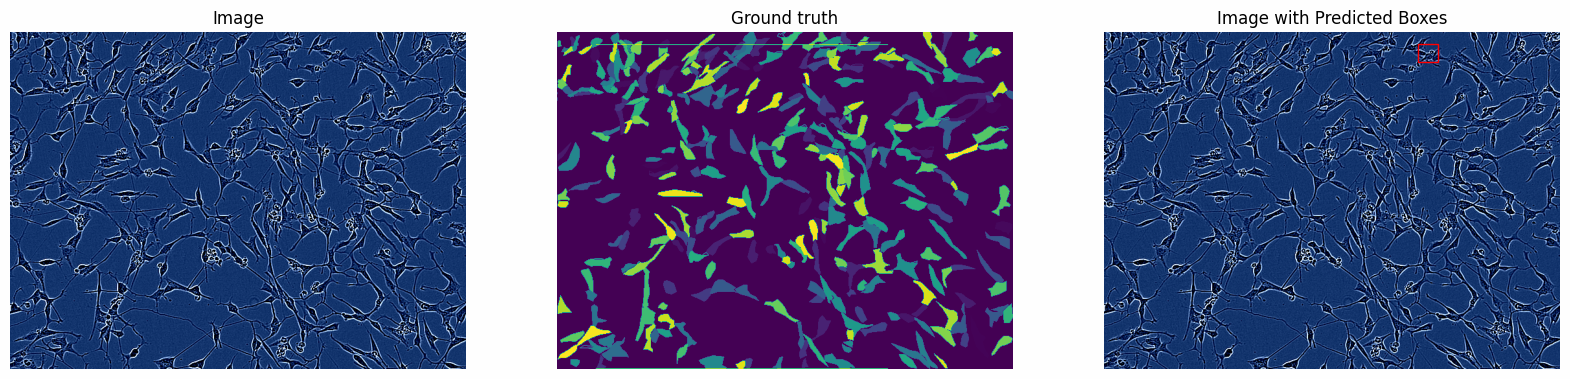

In [ ]:
 #Plots: the image, The image + the ground truth mask + detection boxes, The image + the predicted mask + predicted boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import random


def add_boxes(ax, boxes, color='red'):
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

def analyze_sample(model, ds_train, sample_index):
    '''
    model : model used to create the masks/boxes of the object detection
    ds_train : data set to take samples from
    sample_index: index of the image that will be used
    Returns grid 1x3 with : the image | the image + the ground truth mask + detection boxes | the image + the predicted mask + predicted boxes
    '''





    for i, batch in enumerate(dl_train, start=1):
      if i < 200:
        images, targets = batch


        #print(f"Training Image {targets['file_path'][0]}")

        # img, targets = ds_train[sample_index]
        # img_input = img.unsqueeze(0)
        img = images[0]
        img_1 = img.unsqueeze(dim=0)
        img_input = img_1.to(device)
        with torch.no_grad():
          print(img_input.shape)

          preds = model(img_input)
          print("Boxes are: ", preds['pred_boxes'])

          probabilities = torch.sigmoid(preds['pred_logits'])
          # Find the indices of the max probabilities
          max_indices = torch.argmax(probabilities, dim=-1)
          #print(max_indices)
          not_last_index_count = torch.sum(max_indices != (4 - 1))
          print("targets type ", type(targets['labels']) )
          print("targets len ", len(targets['labels']) )
          num_objects_gt = targets['labels'][0].shape[0]
          #num_objects_gt = targets['labels'].shape[0]
          missing_objects = num_objects_gt-not_last_index_count
          print(f"Objects found: {not_last_index_count.item()} objects loss: {missing_objects}", )

          #print(preds['pred_logits'])
          filtered_preds = filter_boxes(preds)  # This should filter based on scores or other criteria
          print("Filtered Boxes are: ", filtered_preds)
          # Convert boxes from normalized to pixel scale
          pred_boxes_original = denormalize_and_convert_bbox_xyxy(filtered_preds, img.shape[1], img.shape[2])
          print(len(pred_boxes_original))
          for index, box in enumerate(pred_boxes_original):
            print(f"Box number: {index} ha values {box}")


          if not_last_index_count.item() > 5 and not_last_index_count.item() < 800 :
            break




    print(pred_boxes_original)
    fig, axs = plt.subplots(1, 3, figsize=(20, 40), facecolor="#fefefe")

    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH))
    boxes = np.zeros((IMG_HEIGHT, IMG_WIDTH))

    axs[0].imshow(img.numpy().transpose((1,2,0)))
    axs[0].set_title("Image")
    axs[0].axis("off")

    for mask in targets['masks']:
        box = find_bounding_box(mask)
        boxes = np.logical_or(boxes, create_boxed_image(box))

    masks = merge_masks(targets['masks'][0], 0.5)
    #masks = merge_masks(targets['masks'], 0.5)
    detections = merge_masks_and_boxes(masks, boxes)
    axs[1].imshow(detections)
    axs[1].set_title("Ground truth")
    axs[1].axis("off")

    # model.eval()
    # with torch.no_grad():

    #     #print(img_input[0][0])
    #     img_input = img_input.to(device)
    #     preds = model(img_input, train_seg_head=False)
    #     filtered_preds = filter_boxes(preds)
    #     #print(filtered_preds)

    # # Denormalize and convert prediction boxes to xyxy format
    # pred_boxes_original = denormalize_and_convert_bbox_xyxy(filtered_preds, 520, 704)


    axs[2].imshow(img.cpu().numpy().transpose((1,2,0)))



    axs[2].imshow(img.numpy().transpose(1, 2, 0))
    add_boxes(axs[2], pred_boxes_original, color='red')
    axs[2].set_title("Image with Predicted Boxes")
    axs[2].axis("off")
    plt.show()
analyze_sample(model, train_dataset, 404)

In [ ]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = WheatDataset(image_ids=df_valid.index.values,
                                 dataframe=marking,
                                 transforms=get_valid_transforms()
                                )

    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)

    images, targets, image_ids = next(iter(valid_data_loader))
    _,h,w = images[0].shape # for de normalizing images

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)


    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]

    for box,p in zip(oboxes,prob):

        if p >0.5:
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)

    ax.set_axis_off()
    ax.imshow(sample)

In [ ]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("./detr_best_0.pth"))
view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))

# End Notes

I will further add information about various losses that DETR uses , how is criterion declared , what are its parameters exactly,what is hungarian matcher , a little intuition

* We trained one epoch that too for a single fold, but  Detr seems to work fairly well.
* I hope you liked my effort , trying hands with this new model
* If this kernel receives love,I plan to fine tune DETR,run all five folds and publish an inference kernel using WBF for this competition, I belive this can score above 0.74 without any pseudo labelling tricks
* I also plan to include visualization of attentionn weights in the next version along with first fold fully trained on 30-35 epochs with a good lr scdeduler
* I tried to write a genric code so that this can be used with any general object detection dataset and tasks


<font color='red'>Please consider upvoting if my efforts helped you or made you excited about DETR</font>